# Week 2 • Exercise 1: Exploring Word Embeddings (PPMI + SVD)

**Theme:** From one-hot counts to distributed embeddings  
**Focus:** Build embeddings via co-occurrence, PPMI weighting, and dimensionality reduction (SVD)

**You will:**
1) Tokenise a tiny corpus and build a word co-occurrence matrix
2) Compute PPMI to weight informative co-occurrences
3) Create low-dimensional embeddings via Truncated SVD
4) Run similarity and simple analogy queries
5) Visualise a small neighbourhood in 2-D

**Estimated time:** 45–60 minutes


## 0. Imports and seed
This exercise uses only NumPy, SciPy and scikit-learn (all work well on Colab), plus matplotlib for plots.


In [1]:
import numpy as np
from numpy.linalg import norm
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import random

np.random.seed(42)
random.seed(42)


## 1. Toy corpus and preprocessing
We use a small corpus so the maths is clear and runs quickly.  
Feel free to add your own sentences to see how the embeddings change.


In [2]:
corpus = [
    "paris is the capital of france",
    "rome is the capital of italy",
    "madrid is the capital of spain",
    "london is the capital of england",
    "berlin is the capital of germany",
    "the king and the queen visited the city",
    "the prince and princess love the palace",
    "apples and bananas are fruit",
    "oranges and grapes are fruit",
    "the city has a palace and a river",
]

def tokenize(s):
    return [w.strip().lower() for w in s.split() if w.strip()]

tokenised = [tokenize(s) for s in corpus]

# Build vocabulary
vocab = sorted({w for sent in tokenised for w in sent})
w2i = {w:i for i,w in enumerate(vocab)}
i2w = {i:w for w,i in w2i.items()}
V = len(vocab)
V
print(i2w)


{0: 'a', 1: 'and', 2: 'apples', 3: 'are', 4: 'bananas', 5: 'berlin', 6: 'capital', 7: 'city', 8: 'england', 9: 'france', 10: 'fruit', 11: 'germany', 12: 'grapes', 13: 'has', 14: 'is', 15: 'italy', 16: 'king', 17: 'london', 18: 'love', 19: 'madrid', 20: 'of', 21: 'oranges', 22: 'palace', 23: 'paris', 24: 'prince', 25: 'princess', 26: 'queen', 27: 'river', 28: 'rome', 29: 'spain', 30: 'the', 31: 'visited'}


## 2. Co-occurrence matrix (symmetric window)
Count how often words co-occur within a window around each token.  
We will use a small window so the signal is local.


In [3]:
window = 2  # tokens on each side
rows, cols, data = [], [], []

for sent in tokenised:
    idxs = [w2i[w] for w in sent]
    for center_pos, center in enumerate(idxs):
        left = max(0, center_pos - window)
        right = min(len(idxs), center_pos + window + 1)
        for ctx_pos in range(left, right):
            if ctx_pos == center_pos:
                continue
            ctx = idxs[ctx_pos]
            rows.append(center)
            cols.append(ctx)
            # every individual co-occurrence counts as 1
            data.append(1.0)

# The addition of duplicates is handled by coo_matrix
C = sp.coo_matrix((data, (rows, cols)), shape=(V, V), dtype=np.float64).tocsr()
print(C)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 132 stored elements and shape (32, 32)>
  Coords	Values
  (0, 1)	2.0
  (0, 7)	1.0
  (0, 13)	1.0
  (0, 22)	2.0
  (0, 27)	1.0
  (1, 0)	2.0
  (1, 2)	1.0
  (1, 3)	2.0
  (1, 4)	1.0
  (1, 12)	1.0
  (1, 16)	1.0
  (1, 18)	1.0
  (1, 21)	1.0
  (1, 22)	1.0
  (1, 24)	1.0
  (1, 25)	1.0
  (1, 26)	1.0
  (1, 27)	1.0
  (1, 30)	3.0
  (2, 1)	1.0
  (2, 4)	1.0
  (3, 1)	2.0
  (3, 4)	1.0
  (3, 10)	2.0
  (3, 12)	1.0
  :	:
  (28, 14)	1.0
  (28, 30)	1.0
  (29, 6)	1.0
  (29, 20)	1.0
  (30, 1)	3.0
  (30, 5)	1.0
  (30, 6)	5.0
  (30, 7)	2.0
  (30, 13)	1.0
  (30, 14)	5.0
  (30, 16)	2.0
  (30, 17)	1.0
  (30, 18)	1.0
  (30, 19)	1.0
  (30, 20)	5.0
  (30, 22)	1.0
  (30, 23)	1.0
  (30, 24)	1.0
  (30, 25)	1.0
  (30, 26)	2.0
  (30, 28)	1.0
  (30, 31)	2.0
  (31, 7)	1.0
  (31, 26)	1.0
  (31, 30)	2.0


## 3. PPMI weighting
Pointwise Positive Mutual Information emphasises informative co-occurrences over raw counts.

In [12]:
# Convert to probabilities
total = C.sum()
p_wc = C / total                            # joint probability P(w,c)
p_w  = np.asarray(C.sum(axis=1)).ravel() / total  # P(w)
p_c  = np.asarray(C.sum(axis=0)).ravel() / total  # P(c)

# To compute PMI(w,c) = log( P(w,c) / (P(w)P(c)) )
# We need broadcasting with sparse matrix -> compute on nonzeros
C_coo = C.tocoo(copy=True)
pmi_data = []
for w, c, val in zip(C_coo.row, C_coo.col, C_coo.data):
    pwc = val / total
    denom = p_w[w] * p_c[c] + 1e-12
    pmi = np.log(pwc / denom + 1e-12)
    pmi_data.append(max(pmi, 0.0))  # PPMI = max(PMI, 0)

PPMI = sp.coo_matrix((pmi_data, (C_coo.row, C_coo.col)), shape=C.shape).tocsr()
PPMI
for i in range(V):
    print(f"{i2w[i]:15s}: ", end="")
    row = PPMI.getrow(i).toarray().ravel()
    top_ctx = np.argsort(-row)[:5]
    for ctx in top_ctx:
        if row[ctx] > 0:
            print(f"{i2w[ctx]}({row[ctx]:.2f}) ", end="")
    print()
# print the loweest non-zero PPMI value
ppmi_values = PPMI.data
print(f"Lowest non-zero PPMI value: {np.min(ppmi_values):.4f}")


a              : river(2.62) palace(2.21) has(1.93) city(1.70) and(1.11) 
and            : oranges(1.67) apples(1.67) river(1.67) are(1.27) prince(1.27) 
apples         : bananas(3.18) and(1.67) 
are            : fruit(2.77) bananas(2.08) grapes(2.08) and(1.27) 
bananas        : apples(3.18) fruit(2.48) are(2.08) and(0.98) 
berlin         : is(1.86) the(0.98) 
capital        : italy(1.57) germany(1.57) france(1.57) england(1.57) spain(1.57) 
city           : visited(2.26) has(2.26) a(1.70) the(0.76) 
england        : of(1.86) capital(1.57) 
france         : of(1.86) capital(1.57) 
fruit          : are(2.77) bananas(2.48) grapes(2.48) 
germany        : of(1.86) capital(1.57) 
grapes         : oranges(3.18) fruit(2.48) are(2.08) and(0.98) 
has            : city(2.26) palace(2.08) a(1.93) the(0.29) 
is             : london(1.86) rome(1.86) madrid(1.86) berlin(1.86) paris(1.86) 
italy          : of(1.86) capital(1.57) 
king           : the(1.27) and(1.27) 
london         : is(1.86) the(0.9

## 4. Low-dimensional embeddings via Truncated SVD
We factor PPMI to obtain dense embeddings.  
**dim** controls the size of the word vectors.


In [5]:
dim = 50 if V > 50 else min(20, V)  # small but expressive
svd = TruncatedSVD(n_components=dim, random_state=42)
W = svd.fit_transform(PPMI)   # W[i] is the embedding for word i
W.shape


(32, 20)

## 5. Similarity and neighbours
Cosine similarity should rank semantically related words as nearer.


In [6]:
def cosine_sim(a, b, eps=1e-9):
    return float(np.dot(a, b) / (norm(a)*norm(b) + eps))

def most_similar(word, topn=5):
    if word not in w2i:
        raise KeyError(f"'{word}' not in vocab.")
    vec = W[w2i[word]]
    sims = []
    for w in vocab:
        if w == word:
            continue
        sims.append((w, cosine_sim(vec, W[w2i[w]])))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topn]

for probe in ["king", "queen", "paris", "fruit", "palace"]:
    if probe in w2i:
        print(f"\nTop neighbours for '{probe}':")
        for w, s in most_similar(probe, topn=5):
            print(f"  {w:>10s}  sim={s:.3f}")



Top neighbours for 'king':
       queen  sim=0.541
      prince  sim=0.459
       river  sim=0.415
     oranges  sim=0.363
      apples  sim=0.363

Top neighbours for 'queen':
        city  sim=0.635
        king  sim=0.541
         the  sim=0.278
      prince  sim=0.205
       river  sim=0.187

Top neighbours for 'paris':
      berlin  sim=1.000
      london  sim=1.000
      madrid  sim=1.000
        rome  sim=1.000
        king  sim=0.358

Top neighbours for 'fruit':
         are  sim=0.545
     oranges  sim=0.495
      apples  sim=0.495
         and  sim=0.424
     bananas  sim=0.278

Top neighbours for 'palace':
        city  sim=0.631
       river  sim=0.589
    princess  sim=0.403
         has  sim=0.316
           a  sim=0.282


**Checkpoint:**  
- Pick two probes not shown above and list their top 5 neighbours.  
- Do the neighbours make sense given the corpus? Briefly explain.


In [13]:
for probe in ["england", "love"]:
    if probe in w2i:
        print(f"\nTop neighbours for '{probe}':")
        for w, s in most_similar(probe, topn=5):
            print(f"  {w:>10s}  sim={s:.3f}")


Top neighbours for 'england':
      france  sim=1.000
     germany  sim=1.000
       italy  sim=1.000
       spain  sim=1.000
     capital  sim=0.231

Top neighbours for 'love':
      prince  sim=0.817
           a  sim=0.381
         has  sim=0.372
        king  sim=0.281
         and  sim=0.244


## 6. Simple analogies (best effort on tiny data)
We attempt **a : b :: c : ?** using vector arithmetic **b − a + c**  
Note: with very small corpora, analogies may be noisy, which is an instructive limitation.


In [ ]:
def analogy(a, b, c, topn=5, exclude_input=True):
    for w in (a,b,c):
        if w not in w2i:
            raise KeyError(f"'{w}' not in vocab.")
    target = W[w2i[b]] - W[w2i[a]] + W[w2i[c]]
    sims = []
    for w in vocab:
        if exclude_input and w in {a,b,c}:
            continue
        sims.append((w, cosine_sim(target, W[w2i[w]])))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topn]

queries = [
    ("man", "king", "woman"),
    ("paris", "france", "italy"),
    ("queen", "woman", "man"),
]

for a,b,c in queries:
    if all(w in w2i for w in (a,b,c)):
        print(f"\nAnalogy: {a} : {b} :: {c} : ?")
        for w, s in analogy(a,b,c, topn=5):
            print(f"  {w:>10s}  sim={s:.3f}")

# So the model says: “Italy is to … England, Germany, or Spain.” It completely missed Rome.

paris france italy

Analogy: paris : france :: italy : ?
     england  sim=0.918
     germany  sim=0.918
       spain  sim=0.918
          of  sim=0.135
          is  sim=0.134


**Reflection:**  
- Which analogy worked best, and which failed?  
- Given the small corpus, why might analogies be unreliable?  
- How could a larger, domain-relevant corpus improve results?


## 7. 2-D visualisation (PCA)
Project a handful of words to 2-D to see clusters.


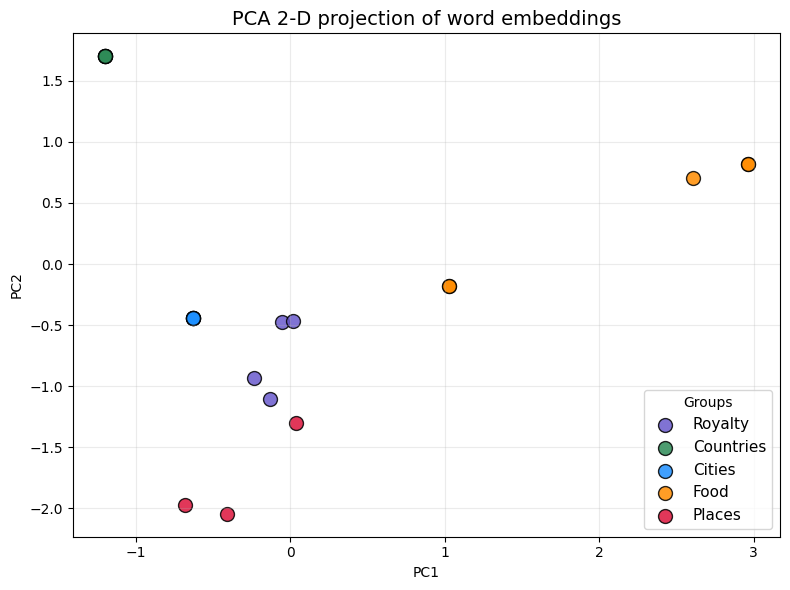

In [17]:
# ===== Clean 2-D PCA visualisation (no word labels) =====
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


selected_groups = {
    "Royalty":   ["king", "queen", "prince", "princess"],
    "Countries": ["france", "italy", "spain", "england", "germany"],
    "Cities":    ["paris", "rome", "madrid", "london", "berlin"],
    "Food":      ["apples", "bananas", "oranges", "grapes", "fruit"],
    "Places":    ["palace", "city", "river"],
}

# Collect vectors again
labels, groups, vecs = [], [], []
for group, words in selected_groups.items():
    for w in words:
        if w in w2i:
            labels.append(w)
            groups.append(group)
            vecs.append(W[w2i[w]])

vecs = np.array(vecs, dtype=float)

# PCA -> 2D
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(vecs)
X2 = np.nan_to_num(X2, copy=False)

# Colour palette
palette = {
    "Royalty":   "#6A5ACD",
    "Countries": "#2E8B57",
    "Cities":    "#1E90FF",
    "Food":      "#FF8C00",
    "Places":    "#DC143C"
}

plt.figure(figsize=(8,6))
ax = plt.gca()

# Scatter points by group, without text
for group in selected_groups.keys():
    idxs = [i for i, g in enumerate(groups) if g == group]
    if not idxs:
        continue
    ax.scatter(X2[idxs,0], X2[idxs,1],
               s=100, alpha=0.85, label=group, c=palette[group], edgecolors="k")

ax.set_title("PCA 2-D projection of word embeddings", fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True, alpha=0.25)
ax.legend(frameon=True, fontsize=11, loc="best", title="Groups")

plt.tight_layout()
plt.show()


# Now try any word from vocabulary.

In [18]:
# Print the vocabulary for quick reference
print("Vocabulary size:", len(vocab))
print("Words in vocabulary:")
print(sorted(vocab))


Vocabulary size: 32
Words in vocabulary:
['a', 'and', 'apples', 'are', 'bananas', 'berlin', 'capital', 'city', 'england', 'france', 'fruit', 'germany', 'grapes', 'has', 'is', 'italy', 'king', 'london', 'love', 'madrid', 'of', 'oranges', 'palace', 'paris', 'prince', 'princess', 'queen', 'river', 'rome', 'spain', 'the', 'visited']


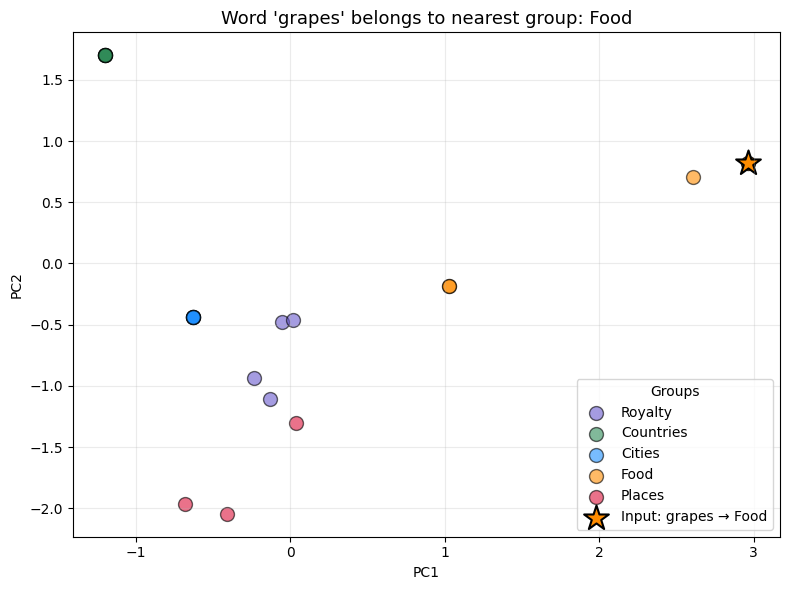

In [21]:
def plot_with_word(word):
    if word not in w2i:
        print(f"'{word}' not in vocab. Try another word.")
        return

    # Project existing words (already fit PCA as pca2, X2)
    # Project the input word
    w2d = pca2.transform(W[w2i[word]].reshape(1, -1))[0]

    # Find nearest group centroid
    centroids = {}
    for g, words in selected_groups.items():
        vecs_g = [W[w2i[w]] for w in words if w in w2i]
        if vecs_g:
            centroids[g] = np.mean(np.vstack(vecs_g), axis=0)

    def cosine_sim(a, b, eps=1e-9):
        return float(np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b) + eps))

    ng, ng_centroid = max(centroids.items(), key=lambda kv: cosine_sim(W[w2i[word]], kv[1]))
    colour = palette.get(ng, "black")

    plt.figure(figsize=(8,6))
    ax = plt.gca()

    # Plot all existing words by group (points only, no labels)
    for group in selected_groups.keys():
        idxs = [i for i, g in enumerate(groups) if g == group]
        if not idxs:
            continue
        ax.scatter(X2[idxs,0], X2[idxs,1],
                   s=100, alpha=0.6, label=group, c=palette[group], edgecolors="k")

    # Highlight the input word
    ax.scatter(w2d[0], w2d[1],
               marker="*", s=350, c=colour, edgecolors="k", linewidth=1.5,
               label=f"Input: {word} → {ng}")

    ax.set_title(f"Word '{word}' belongs to nearest group: {ng}", fontsize=13)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.25)
    ax.legend(frameon=True, fontsize=10, loc="best", title="Groups")

    plt.tight_layout()
    plt.show()

# Example usage
plot_with_word("grapes")


## 📝 Take-Away from Exercise 1

This exercise connected our lecture concepts to hands-on practice:

- **From one-hot to distributed vectors:** We saw how one-hot encodings cannot express similarity, while dense embeddings cluster semantically related words.
- **Co-occurrence & PPMI embeddings:** Even with a tiny toy corpus, embeddings captured useful neighbourhoods (e.g. fruit with fruit, royalty with royalty).
- **Analogy arithmetic:** Vector operations can reflect semantic relations (king – man + woman ≈ queen), but performance suffers with limited data — showing why larger corpora and models like Word2Vec are powerful.
- **Visualisation:** PCA projections helped us see semantic clusters, but also reminded us that dimensionality reduction can distort some distances.
- **OOV limitation:** If a word is not in the vocabulary, the model cannot represent it. This “out-of-vocabulary problem” is a fundamental limitation of classical embeddings.
- **Link to lecture:** These limitations motivate modern approaches like Word2Vec, neural networks, and eventually RNNs and Transformers that handle larger vocabularies, sequences, and generalisation.

👉 **Key insight:** Classical embeddings give us a big step up from Bag-of-Words, but they are only as good as the data they are trained on. Understanding their strengths *and* their limits prepares us for the transition to Word2Vec and sequence models in the next exercises.


## 8. Short written reflection (3–5 sentences)
1) Name one cluster you observe and why it forms.  
2) Describe one limitation of PCA for interpreting embeddings.  
3) In an application you care about, when would these embeddings be preferable to TF-IDF, and when not?


## 9. Extensions (optional)
- Increase the corpus size with your own sentences and re-run Sections 2–7.  
- Try a larger window or smoothing to see how neighbours change.  
- Replace Truncated SVD with t-SNE or UMAP for visualisation (slower, but can show curved manifolds).  
- Initialise an embedding layer in a small RNN with these vectors (preview for Exercise 4).
